In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from utils.models import RGCN_v1, gwnet_wrapper
from utils.xai_utils import integrated_gradients
import seaborn as sns

plt.style.use('dark_background')
np.random.seed(123)
torch.manual_seed(123)

# Set up general arguments and pull in some real River-dl data

In [2]:
## Define some general arguments for the notebook
mod = 'GWN'  #GWN or RGCN
base = 'mean' #zeros or mean
grad_steps = 5 #Number of steps to take in calculation of IG
year_index = -1 #Sequence to apply IG to
weights_file = f'../../river-dl/results/baseline/{mod}/rep_5/finetuned_weights.pth'
prepped_file = f"../../river-dl/results/baseline/{mod}/prepped.npz"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
pred_length = 15

river_dl = np.load(prepped_file)
num_vars = len(river_dl['x_vars'])
seq_len = river_dl['x_trn'].shape[1]
adj_matrix = river_dl['dist_matrix']
n_segs = adj_matrix.shape[0]

if base == 'zeros':
    x = torch.from_numpy(river_dl['x_trn']).float()[455*year_index:]
    baseline = torch.zeros_like(x)

elif base == 'mean':
    x = torch.from_numpy(river_dl['x_trn']).float()
    n_series = river_dl['x_trn'].shape[0]
    baseline = x.reshape(n_series//n_segs,n_segs,seq_len,num_vars)
    baseline = torch.mean(baseline,dim=0)
    x = x[455*year_index:]

dates_x = river_dl['times_trn'][455*year_index:][0].flatten()


x.shape,baseline.shape, adj_matrix.shape

(torch.Size([455, 60, 7]), torch.Size([455, 60, 7]), (455, 455))

In [5]:
if mod == 'RGCN':
    model = RGCN_v1(num_vars, 20, adj_matrix)
    model.load_state_dict(torch.load(weights_file, map_location=device))

elif mod == 'GWN':
    supports = [torch.tensor(adj_matrix).to(device).float()]
    out_dim = pred_length
    model = gwnet_wrapper(device,n_segs,supports=supports,aptinit=supports[0],
    in_dim=num_vars,out_dim=out_dim,layers=3, kernel_size=5,blocks=3, weights_path=weights_file,
                          nsegs=n_segs)

model.eval()

373851

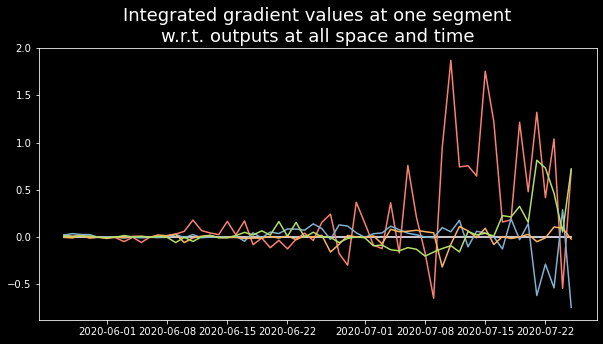

In [4]:
IG_vals = integrated_gradients(x, model, grad_steps, baseline)
plt.figure(figsize = (10, 5))
for i in range(num_vars):
    plt.plot(dates_x, IG_vals[0, :, i])
plt.title('Integrated gradient values at one segment\nw.r.t. outputs at all space and time',
          fontsize = 18);

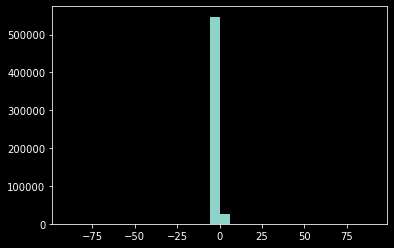

In [50]:
## take a look at distribtuoin of IG vals
plt.hist(IG_vals.flatten(),bins=30)
plt.show()

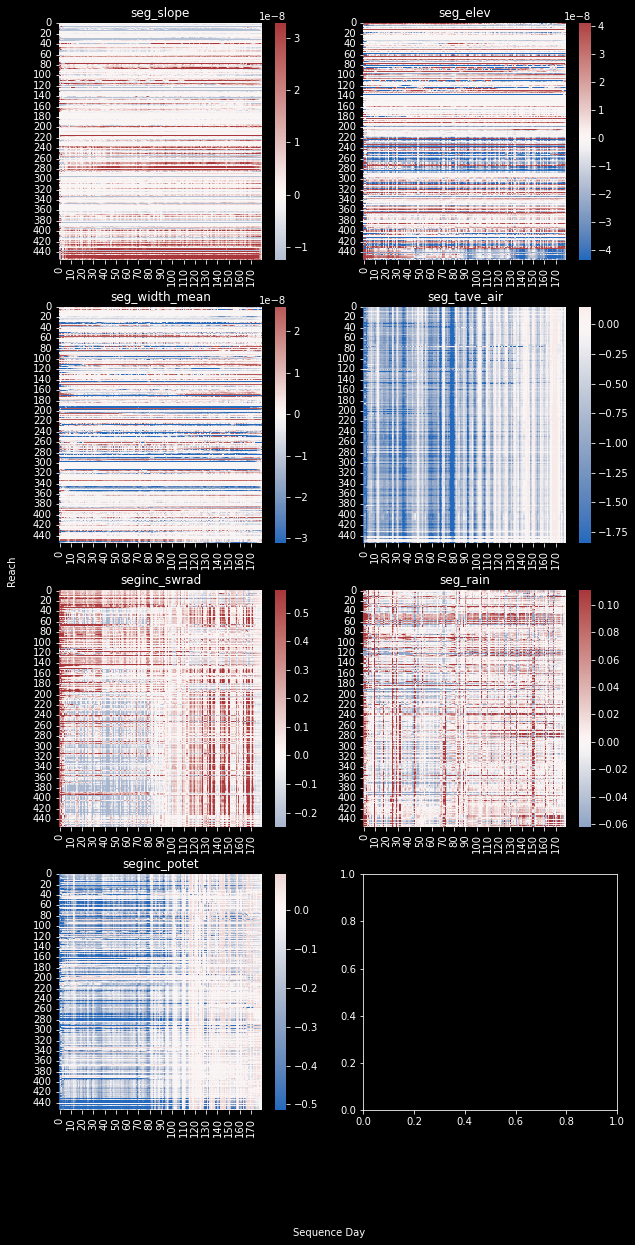

In [51]:
fig, axes = plt.subplots(nrows=4,ncols=2,figsize=(10,20))
#cmap = sns.palplot(sns.diverging_palette(240, 10, n=9))
for i in range(7):
    IG = IG_vals[:,:,i]
    low_lim = np.quantile(IG,.05)
    high_lim = np.quantile(IG,.95)
    sns.heatmap(IG, vmin=low_lim,vmax=high_lim,center=0, cmap='vlag', ax=axes.reshape(-1)[i])
    axes.reshape(-1)[i].set_title(river_dl['x_vars'][i])
fig.text(0.5, 0.04, 'Sequence Day', ha='center', va='center')
fig.text(0.06, 0.5, 'Reach', ha='center', va='center', rotation='vertical')
plt.tight_layout
plt.show()

## lets try to make a seg to seg heatmap

In [52]:
seg2seg_influence = []
for i in range(455):
    IG_vals = integrated_gradients(x, model, grad_steps,baseline, spatial_focus=i)
    reduced = np.mean(IG_vals,axis=1)
    seg2seg_influence.append(reduced)

seg2seg_influence=np.asarray(seg2seg_influence)

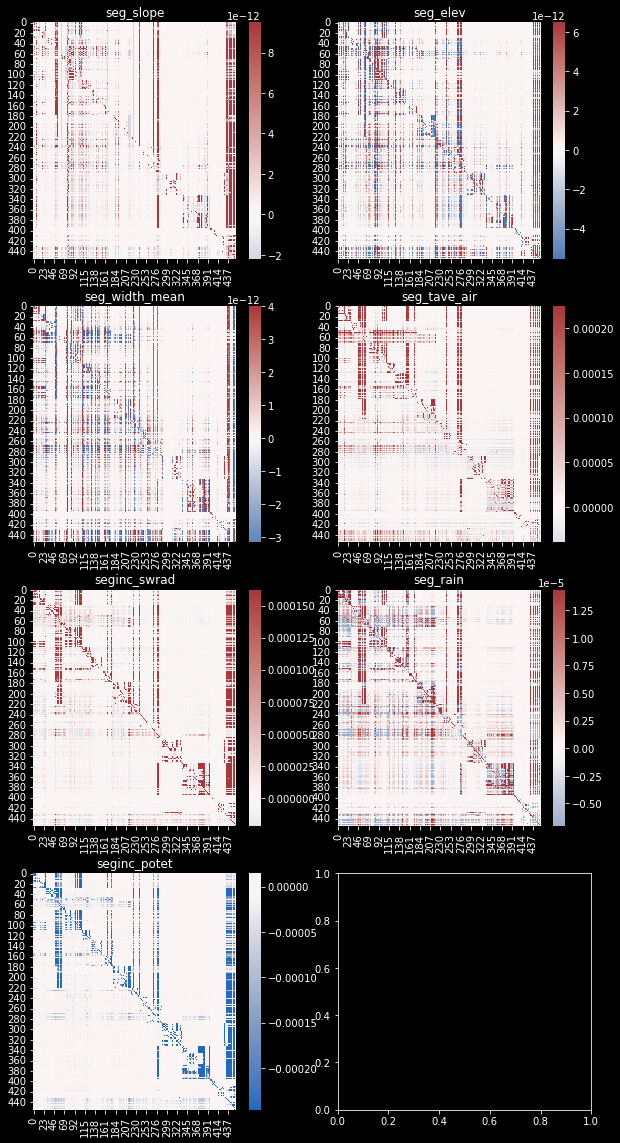

In [53]:
fig, axes = plt.subplots(nrows=4,ncols=2,figsize=(10,20))

for i in range(num_vars):
    IG = seg2seg_influence[:,:,i]
    low_lim = np.quantile(IG,.05)
    high_lim = np.quantile(IG,.95)
    sns.heatmap(IG, vmin=low_lim,vmax=high_lim, center=0,cmap='vlag', ax=axes.reshape(-1)[i])
    axes.reshape(-1)[i].set_title(river_dl['x_vars'][i])

plt.tight_layout
plt.show()


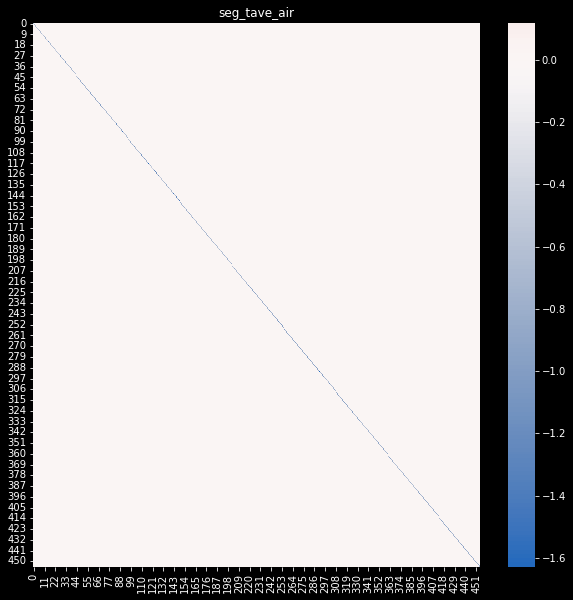

In [54]:
i=3
IG = seg2seg_influence[:,:,i]
#low_lim = np.quantile(IG,.05)
#high_lim = np.quantile(IG,.95)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(IG, cmap='vlag',center=0,ax=ax)
plt.title(river_dl['x_vars'][i])
plt.tight_layout
plt.show()

In [6]:
def noise_segs(seg_of_interest):
    with torch.no_grad():
        y_hat_original = model(x)#[:,90:180,:]
    x_hypothesis = torch.rand_like(x)
    x_hypothesis[seg_of_interest] = x[seg_of_interest]
    with torch.no_grad():
        y_hat_hypothesis = model(x_hypothesis)#[:,90:180,:]
    y_diff = y_hat_original[seg_of_interest, :].detach() - y_hat_hypothesis[seg_of_interest, :].detach()
    y_diff = np.mean(y_diff.numpy())
    return y_diff

In [7]:
diffs =[]
for i in range(455):
    d = noise_segs(i)
    diffs.append(d)

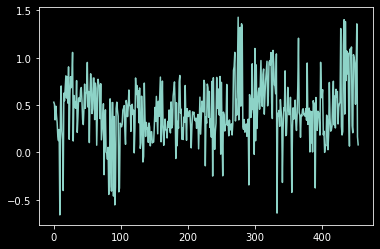

In [8]:
plt.plot(diffs)

In [11]:
import fiona
#import geoplot as gplt
import geopandas as gpd
#import geoplot.crs as gcrs

In [12]:
segs = gpd.read_file('../../river-dl/data_DRB/DRB_spatial/segs/segs.shp')
ids = river_dl['ids_trn'][-455:][:,0,:].flatten()
diffs_sf = pd.DataFrame({'sg_d_nt':ids[:len(diffs)], 'diffs':diffs}).merge(segs).set_geometry('geometry')

<AxesSubplot:>

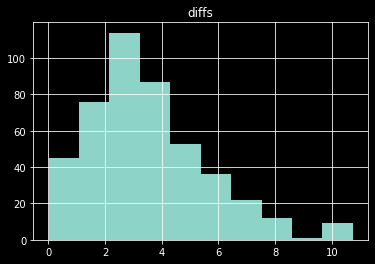

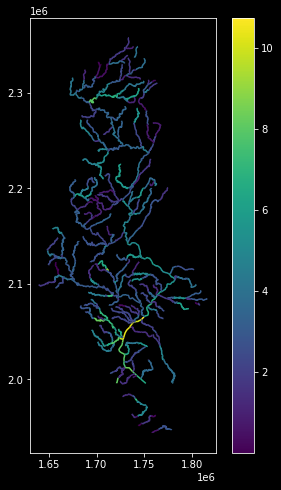

In [13]:
import pandas as pd
diffs_sf['diffs'] = np.abs(diffs_sf.diffs*river_dl['y_std'][0])
diffs_sf.hist('diffs')
fig, ax = plt.subplots(figsize = (6,8))
diffs_sf.plot(column='diffs', ax = ax, legend = True)

In [95]:
model.eval()
%timeit model(x)
#shape_x=x.shape
#x1 = x.reshape(int(shape_x[0] / 455), 455, shape_x[1], shape_x[2]).movedim((1,2,3),(2,3,1))
#yhat=model(x)

4.93 s ± 170 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
